In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import linear_rainbow
from sklearn.metrics import mean_absolute_error, r2_score

In [26]:
df=pd.read_csv('tips (data for regression problem).csv')

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


In [5]:
df.isnull().sum()
df = df.dropna()

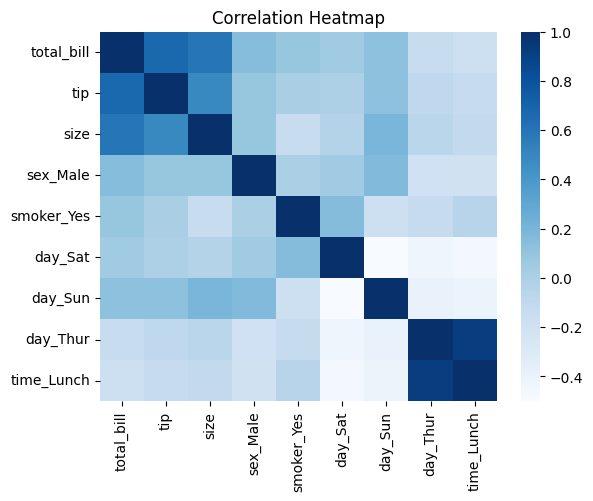

In [10]:
df = pd.get_dummies(df, drop_first=True)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

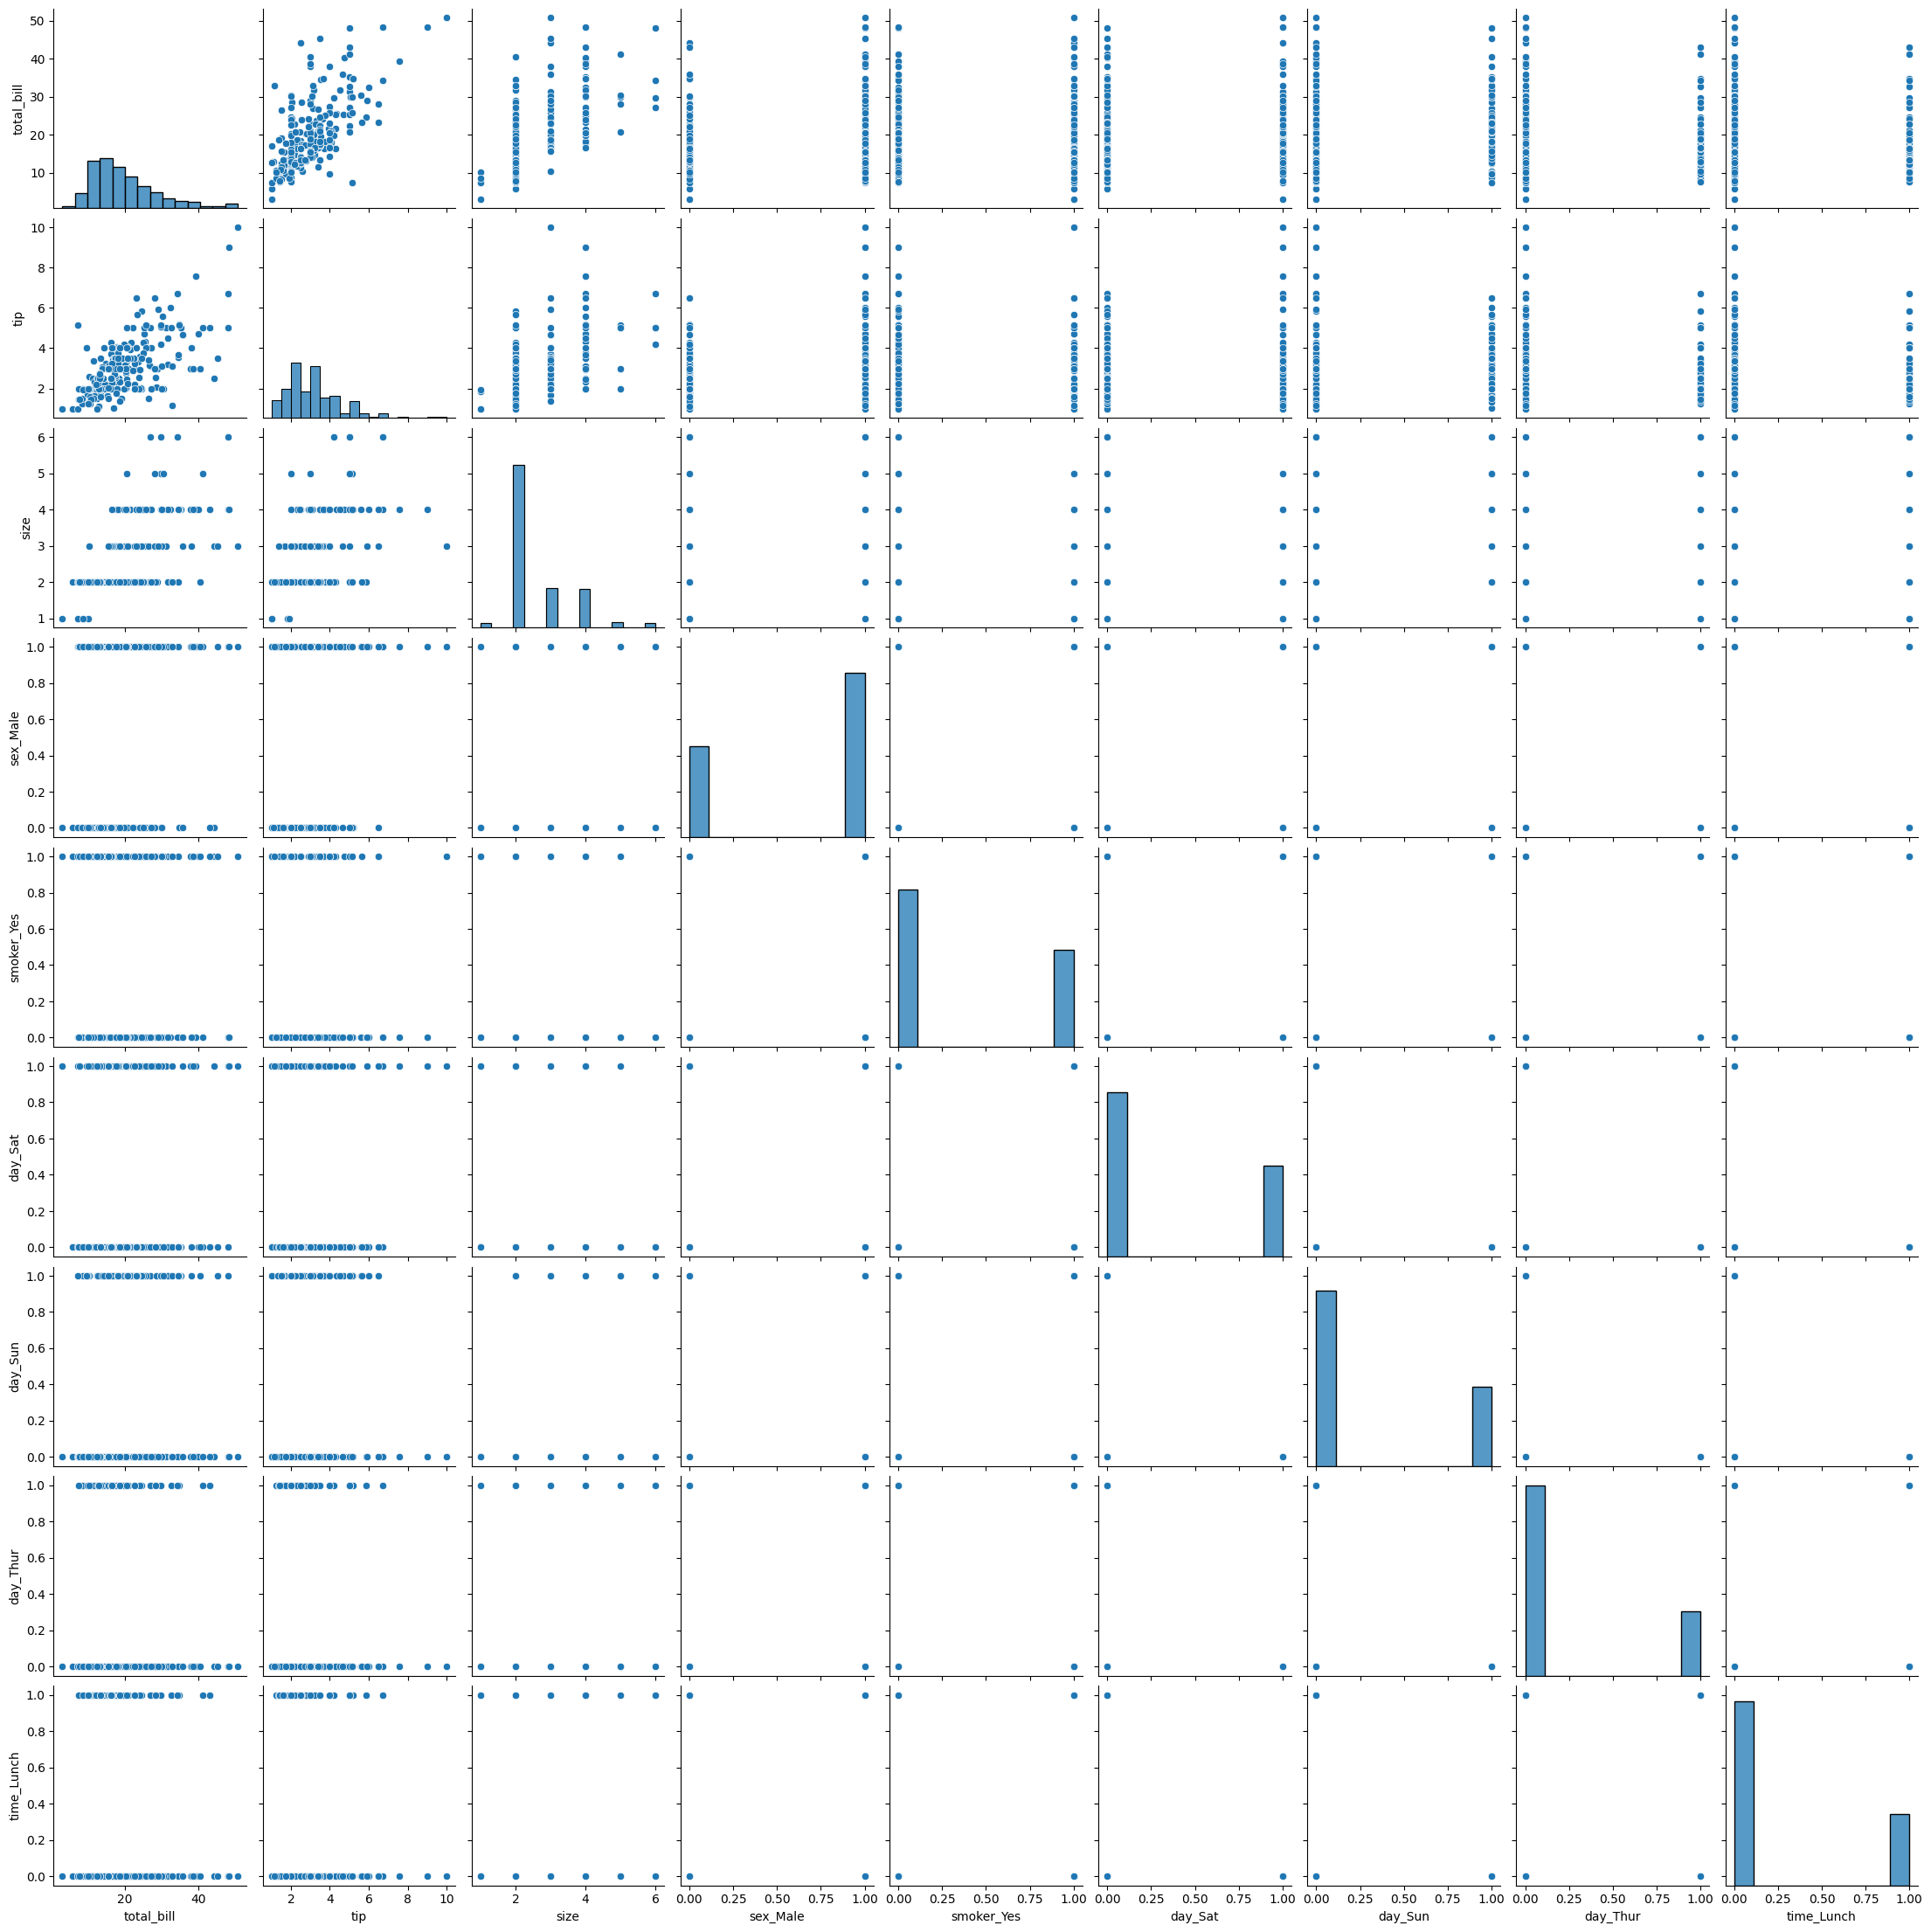

In [11]:
sns.pairplot(df)
plt.show()

Rainbow Test Results: Statistic = 1.5494, P-value = 0.0186
Linearity Assumption: Violated


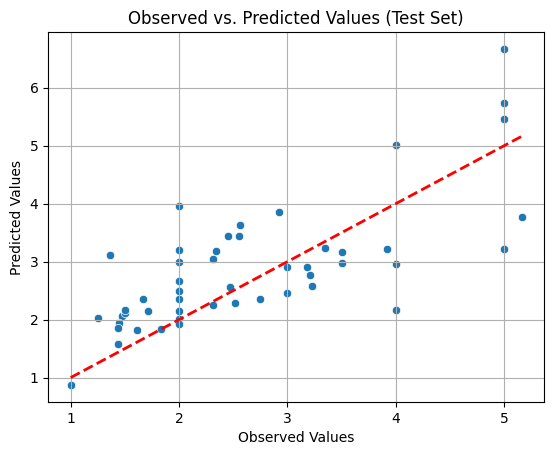

In [15]:
# Splitting the data into features and target variable
X, y = df.drop(columns=['tip']), df['tip']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adding a constant term for the intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fitting the OLS model
model = sm.OLS(y_train, X_train_scaled).fit()

# Performing the Rainbow test for linearity
rainbow_stat, rainbow_pvalue = linear_rainbow(model)
print(f"Rainbow Test Results: Statistic = {rainbow_stat:.4f}, P-value = {rainbow_pvalue:.4f}")
print("Linearity Assumption:", "Valid" if rainbow_pvalue > 0.05 else "Violated")

# Evaluating the model on the test set
y_pred = model.predict(X_test_scaled)

# Plotting Actual vs Predicted values
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Observed vs. Predicted Values (Test Set)")
plt.grid(True)
plt.show()


In [17]:
# Train and evaluate a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_test_predictions = lr_model.predict(X_test_scaled)

# Calculating residuals and performance metrics
residuals = y_test - y_test_predictions
mse_value = mean_squared_error(y_test, y_test_predictions)
r2_value = r2_score(y_test, y_test_predictions)

# Displaying the performance metrics
print(f"Mean Squared Error: {mse_value:.3f}")
print(f"R-squared (R²): {r2_value:.3f}")

# Plotting residuals for model evaluation
# plt.figure(figsize=(10, 6))
# sns.residplot(x=y_test_predictions, y=residuals, lowess=True, 
#               line_kws={'color': 'blue', 'linewidth': 2})
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)
# plt.xlabel("Predicted Values", fontsize=12)
# plt.ylabel("Residuals", fontsize=12)
# plt.title("Residual Plot: Assessing Linearity", fontsize=14)
# plt.grid(alpha=0.5)

# # Annotating the plot with performance metrics
# plt.annotate(f"MSE: {mse_value:.3f}\nR²: {r2_value:.3f}", 
#              xy=(0.75, 0.1), xycoords='axes fraction', 
#              fontsize=10, bbox=dict(facecolor='lightblue', edgecolor='blue', alpha=0.6))

# plt.show()


Mean Squared Error: 0.703
R-squared (R²): 0.437


In [18]:
# Preparing the data
X = df[['total_bill', 'size']]
y = df['tip']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Defining models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
}

# Storing evaluation results and feature importances
evaluation_results = {}
feature_importances = {}

# Training and evaluating models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    evaluation_results[name] = {'MAE': mae, 'R-squared': r2}
    
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        feature_importances[name] = model.coef_
    elif name == 'Random Forest':
        feature_importances[name] = model.feature_importances_

# Displaying evaluation results
print("\nModel Performance Summary:")
for name, metrics in evaluation_results.items():
    print(f"  {name}: MAE = {metrics['MAE']:.3f}, R² = {metrics['R-squared']:.3f}")

# Displaying feature importance
print("\nKey Feature Contributions:")
for name, importance in feature_importances.items():
    print(f"\n{name}:")
    for index, feature in enumerate(X.columns):
        print(f"  {feature} = {importance[index]:.3f}")

# Management insights based on analysis
print("\nBusiness Insights:")
print("- Strategies to encourage larger 'total_bill' values could lead to higher tip amounts.")
print("- Promoting group dining experiences can potentially boost overall tips.")
print("- A focus on enhancing customer experience for larger parties and higher spending groups may be effective.")



Model Performance Summary:
  Linear Regression: MAE = 0.664, R² = 0.481
  Ridge Regression: MAE = 0.664, R² = 0.481
  Lasso Regression: MAE = 0.655, R² = 0.510
  Decision Tree: MAE = 0.818, R² = 0.196
  Random Forest: MAE = 0.728, R² = 0.339
  Support Vector Regression: MAE = 0.591, R² = 0.542
  K-Nearest Neighbors: MAE = 0.675, R² = 0.466

Key Feature Contributions:

Linear Regression:
  total_bill = 0.807
  size = 0.252

Ridge Regression:
  total_bill = 0.802
  size = 0.253

Lasso Regression:
  total_bill = 0.741
  size = 0.187

Random Forest:
  total_bill = 0.904
  size = 0.096

Business Insights:
- Strategies to encourage larger 'total_bill' values could lead to higher tip amounts.
- Promoting group dining experiences can potentially boost overall tips.
- A focus on enhancing customer experience for larger parties and higher spending groups may be effective.


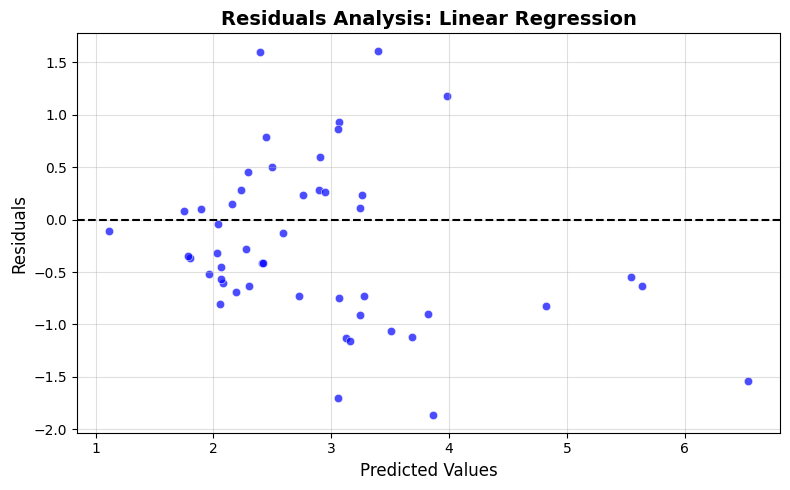

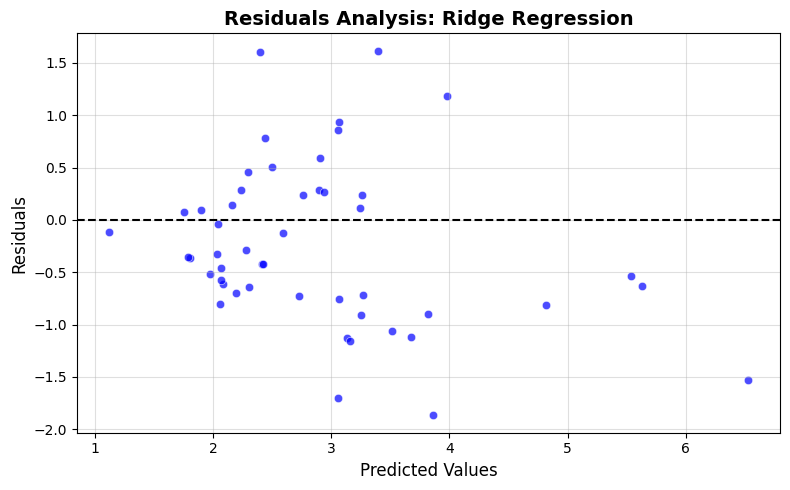

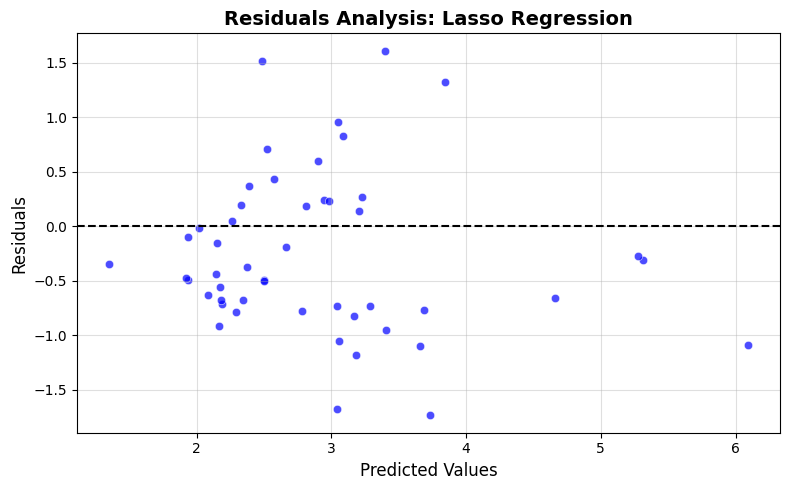

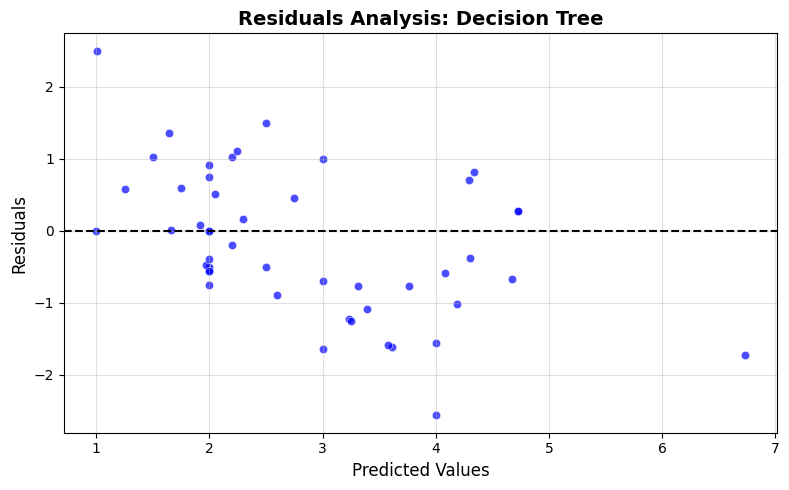

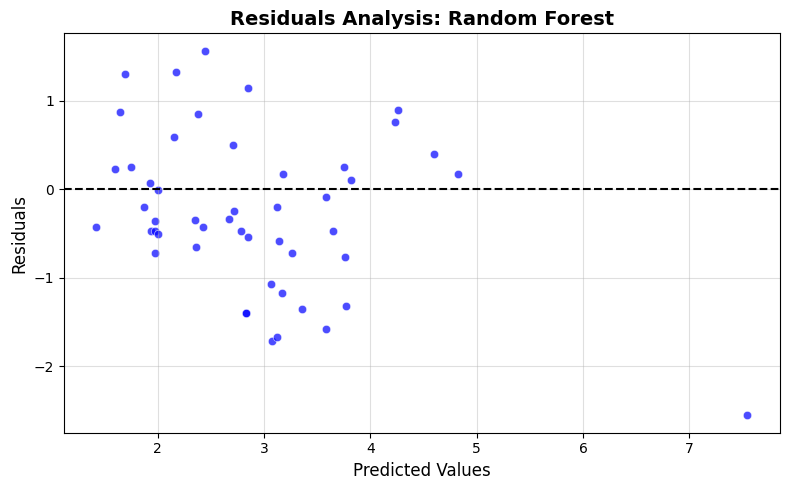

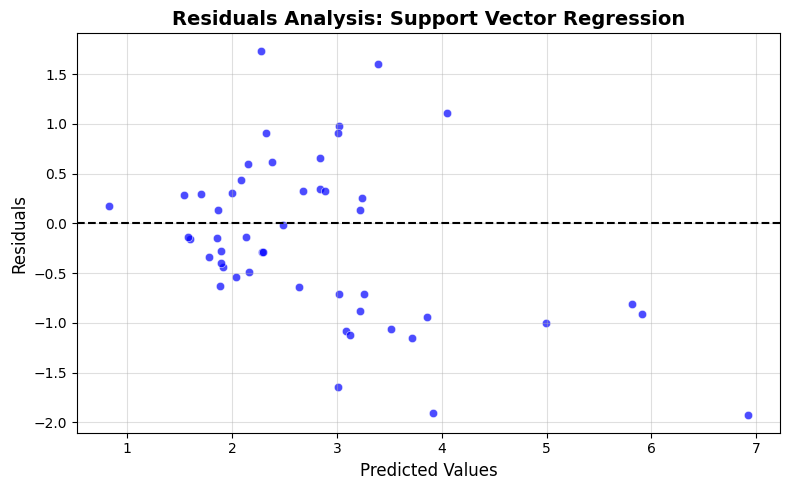

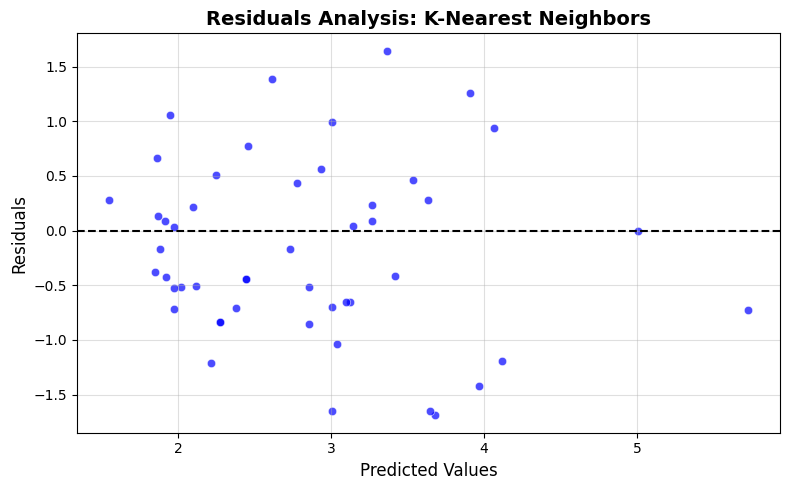

In [19]:
# Define a dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Support Vector Regression': SVR(kernel='linear'),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
}

# Function to visualize residuals for each model
def visualize_residuals(y_actual, y_predicted, model_name):
    residuals = y_actual - y_predicted

    # Plotting residuals
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_predicted, y=residuals, alpha=0.7, color="blue")
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
    plt.grid(alpha=0.4)

    # Adding titles and labels
    plt.title(f"Residuals Analysis: {model_name}", fontsize=14, fontweight='bold')
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.tight_layout()
    plt.show()

# Train, predict, and plot residuals for each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_predictions = model.predict(X_test)

    # Call the visualization function for residuals
    visualize_residuals(y_test, y_predictions, name)


In [24]:
data = pd.get_dummies(df, drop_first=True)
data.head()

,total_bill,tip,size,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,1.01,2,False,False,False,True,False,False
1,10.34,1.66,3,True,False,False,True,False,False
2,21.01,3.50,3,True,False,False,True,False,False
3,23.68,3.31,2,True,False,False,True,False,False
4,24.59,3.61,4,False,False,False,True,False,False


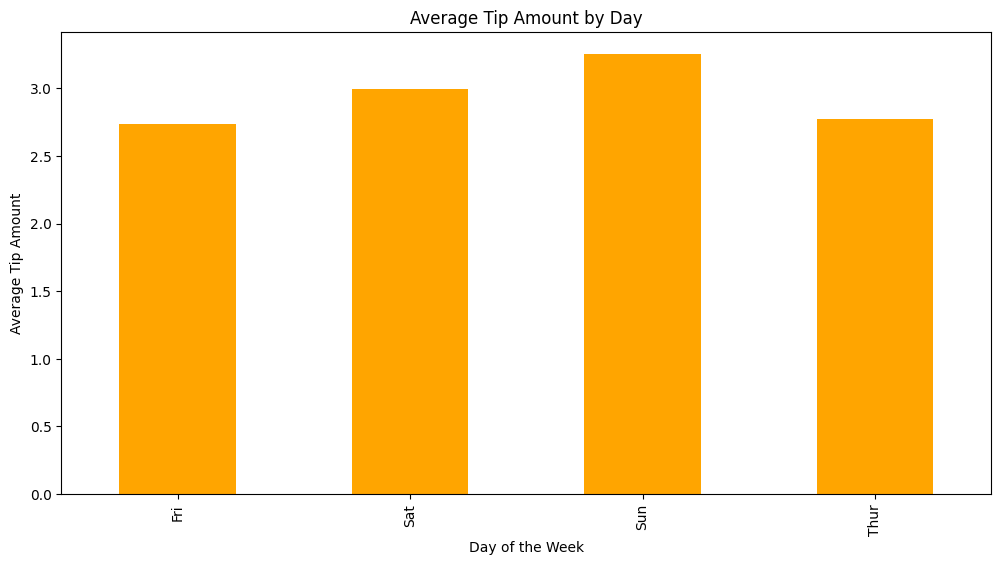

In [27]:
avg_tip_per_day = df.groupby('day')['tip'].mean().sort_index()

# Bar plot for average tip amount per day
plt.figure(figsize=(12, 6))
avg_tip_per_day.plot(kind='bar', color='orange')
plt.title('Average Tip Amount by Day')
plt.xlabel('Day of the Week')
plt.ylabel('Average Tip Amount')
plt.show()

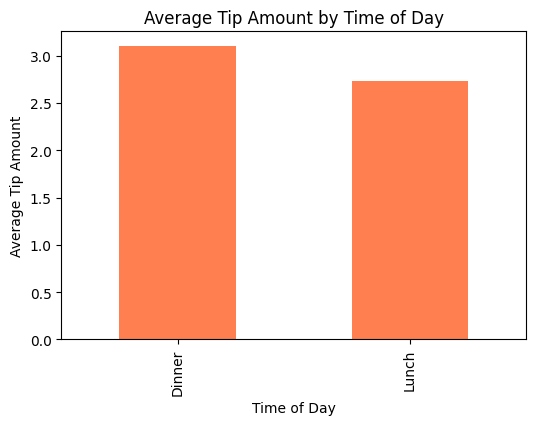

In [28]:
avg_tip_by_time = df.groupby('time')['tip'].mean()

# Bar plot for average tip amount by time of day
plt.figure(figsize=(6, 4))
avg_tip_by_time.plot(kind='bar', color='coral')
plt.title('Average Tip Amount by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Tip Amount')
plt.show()


Conclusion on Tipping Behavior Analysis: Key Insights

Total Bill: Higher bills are correlated with higher tips, suggesting that larger spending directly influences the tip amount.
Party Size: Larger groups tend to leave higher tips, highlighting that accommodating group visits can boost tipping behavior.
Model Accuracy:

Best Performing Models: Both Random Forest and Decision Tree models demonstrated strong predictive accuracy, capturing the intricate relationships within the data effectively.
Regularization Techniques: Ridge and Lasso regularization were beneficial in identifying the most significant features and preventing overfitting, enhancing model generalization.
Insights for Management:

Revenue Optimization: Encouraging customers to spend more and promoting group visits can lead to higher tips, which not only improves service quality but also enhances overall revenue.